<a href="https://colab.research.google.com/github/manjugovindarajan/Women_in_DS_Py/blob/main/Copy_of_WiDSAI_Python_Workshop_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext lab_black

Quickfile is an online tax-prep platform. The company operates in the B2B and B2C space. This project will focus on the B2B client, i.e. will examine Tax Professionals that purchase our product in order to file their clients' taxes. As we know, businesses often break the year up in cycles. This is done so we can measure things. Here, we seek to measure churn. The tax cycle is a bit different in that the tax year ends on April 30th and begins on May 1st.
**Normally, we'd be pulling data from a database. To make this data accessible, we've provided it in CSV files.

![image.png](attachment:603b50b9-6513-4440-8eba-4e41619bccdc.png)

In [ ]:
# Load the pandas and numpy packages
import pandas as pd
import numpy as np

## 2. Identify Tax Years in which a Customer is Active
Our problem focuses in tax years 2021 and 2022.<br>
A Pro customer considered active in tax year 2021 purchases our tax filing product between May 1st, 2021 and April 30th of 2022.<br>
A Pro customer considered active in tax year 2022 purchases our tax filing product between May 1st, 2022 and April 30th of 2023.<br>

In order to understand retention, we need to understand in which tax years a customer is active. As the data exists in our database, this is not immediately clear. Apply conditional logic that identifies in which tax year a customer sale falls.

In [ ]:
# Pull relevant data from our CUSTOMER SALES DATE table (Load the data)
sales_date_df = pd.read_csv("CustomerSalesDate.csv")
# Display the first five rows
sales_date_df.head()

,accountID,salesDate
0,44451402,2022-04-17 16:47:17
1,30492817,2022-04-06 05:50:41
2,16691344,2022-04-01 07:07:08
3,19433773,2022-04-06 03:35:31
4,25169734,2022-04-07 22:52:07


In [ ]:
# check data types! Has the SalesDate column been read in as a date? To check, display the salesDate column
print(sales_date_df["salesDate"])
# convert to a datetime
sales_date_df["salesDate"] = pd.to_datetime(sales_date_df["salesDate"])

0       2022-04-17 16:47:17
1       2022-04-06 05:50:41
2       2022-04-01 07:07:08
3       2022-04-06 03:35:31
4       2022-04-07 22:52:07
               ...         
9168    2022-06-18 12:31:04
9169    2021-07-01 17:46:43
9170    2022-08-23 03:55:26
9171    2022-08-23 19:11:29
9172    2021-07-02 19:23:14
Name: salesDate, Length: 9173, dtype: object


In [ ]:
def get_tax_year(row):
    """
    Assigns a tax year (TY) to a customer based on their purchase date.
    Args:
    row: A row from a pandas DataFrame containing a 'date' column.
    Returns:
    A string representing the tax year (e.g., 'TY20', 'TY21', 'TY22').
    """
    # Define start and end dates for each tax year
    ty21_start = pd.to_datetime("2021-05-01")
    ty21_end = pd.to_datetime("2022-04-30")
    ty22_start = pd.to_datetime("2022-05-01")
    ty22_end = pd.to_datetime("2023-04-30")

    # Conditional logic to assign tax year
    if ty21_start <= row <= ty21_end:
        return "TY21"
    elif ty22_start <= row <= ty22_end:
        return "TY22"
    else:
        return "NA"  # Or any other value for non-qualifying dates

In [ ]:
# APPLY the function to the 'salesDate' column
transactionTaxYear = sales_date_df["salesDate"].apply(get_tax_year)

In [ ]:
# Concatenate the 'transactionTaxYear' pandas Series with the 'accountID' pandas Series
transaction_tax_year_df = pd.concat(
    [sales_date_df["accountID"], transactionTaxYear], axis=1
)

## 3. The tricky part
Once we have identified the tax year in which the purchase took place, we need to designate whether a customer has churned or not. A customer that has churned is active during a specified tax year and then not active the next year. For example, a churned customer would be active in TY21 and not active (i.e. have no history of purchase) in TY22.

In [ ]:
# Group the DataFrame by accountID and aggregate by list
grouped_df = transaction_tax_year_df.groupby("accountID").agg(list)
# Display the grouped dataframe
grouped_df

,salesDate
accountID,
19524,"[TY21, TY22]"
22182,[TY21]
22210,"[TY21, TY22]"
24657,"[TY22, TY21]"
25127,"[TY22, TY21]"
...,...
99851556,"[TY21, TY22]"
99961922,"[TY22, TY21]"
99976143,[TY21]


In [ ]:
# APPLY a lambda function to the transactionTaxYear column:
## IF a list is greater than 1 (customer has multiple years of sales), label as 'non_churned'
## ELSE label 'churned'
labels = grouped_df["salesDate"].apply(
    lambda x: "non_churned" if len(x) > 1 else "churned"
)
# Convert this to a DataFrame (we can actually do this by reseting the index)
labels_df = labels.reset_index()

## 3) Extract Month.
turns out, when in the tax year the Pro signs up indicates his or her success, which is tied to their propensity to churn. Extract the month from the purchase date.

In [ ]:
# Group the DataFrame by accountID and aggregate by the MINimum salesDate
min_sale_df = sales_date_df.groupby(["accountID"]).agg({"salesDate": "min"})
# extract the month from the min_sale_df salesDate column
initialSaleMonth = min_sale_df["salesDate"].dt.month

In [ ]:
account_sales_history_df = labels_df.rename(columns={"salesDate": "label"}).merge(
    initialSaleMonth.reset_index().rename(columns={"salesDate": "saleMonth"}),
    on="accountID",
)

## 4) Merge
Sales history is tracked using an accountID. However, all other attributes about the customer are tracked using a CompanyID.
<br>
Pull data fom our AccountID_CompanyID table.
<br>
Merge a customer's sales history with the customer's CompanyID.

In [ ]:
# Pull data from our AccountID_CompanyID Table
account_company_ID_link_df = pd.read_csv("Account_Company_ID_Linking_Table.csv")
# Merge a customer's Sales History with the customer's CompanyID
customer_sales_history_df = account_company_ID_link_df.merge(
    account_sales_history_df, on="accountID"
)

## 5) Merge Again:)
Now that we have the companyID, we can connect the rest of our data.
<br>
Merge a customer's sales history with the customer's CompanyID.

In [ ]:
# Pull data from our Company Data Table
company_data = pd.read_csv("CompanyID_Data.csv")
# Merge
company_data_df = customer_sales_history_df.merge(
    company_data, on="companyID"
).drop_duplicates(subset=["accountID"])

## 6) Binarize
It's difficult for Machine Learning algorithms to process string data in the productType column in its current state. Let's apply the MultiLabelBinarizer object to expand this string to a series of 0s and 1s, indicating whether the customer has purchased the product or not.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html

In [ ]:
product_type = company_data_df["productType"].apply(lambda x: x.split(","))

In [ ]:
# Import the MultiLabelBinarizer object from the sklean.preprocessing library
from sklearn.preprocessing import MultiLabelBinarizer

# Create a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()
# Apply the fit_transform method to the product type object
numpy_array = mlb.fit_transform(product_type)
# Transform to a DataFrame
dataframe = pd.DataFrame(numpy_array)
# Extract the columns from the mlb.classes object
cols = list(mlb.classes_)
# assign the cols to the dataframe columns
dataframe.columns = cols

## 7) Bin
It's sometimes easier for Machine Learning algorithms to find patterns in the data when data is binned. This essentially transforms a continuous variable to a categorical variable.<br>
Here, we use pandas qcut() function to bin the **customerSpend** column. The qcut() function divides a set of values into bins according to the sample quantiles. With this function, values are divided into bins of equal sizes, which means that each bin has an equal number of samples. The q argument specifies the number of bins we might want to use.

<Axes: >

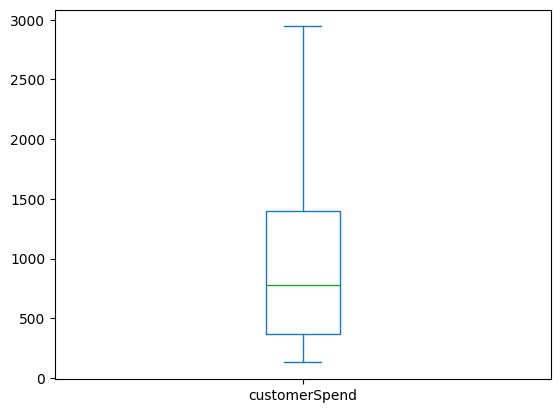

In [ ]:
##HINT: It could be helpful to start with a boxplot to understand the spread. The showfliers argument removes outliers.
##Remove it to see the outliers.
company_data_df["customerSpend"].plot(kind="box", showfliers=False)

In [ ]:
# To make this more readable, we can add labels using the labels argument
customerSpend_bins = pd.qcut(company_data_df["customerSpend"], q=10)

## 8) Count
Another useful tool that counts the number of values within a particular column or Series in a DataFrame.

In [ ]:
company_data_df[
    "firmSize"
].value_counts()  # you can add the normalize=True argument to get the % makeup for each value, e.g. what percentage of the dataset is composed of firmSize=1?

1.0      4444
2.0       431
3.0       184
4.0        90
5.0        60
6.0        33
7.0        25
8.0        22
11.0       11
10.0        8
9.0         7
12.0        6
14.0        5
13.0        5
16.0        5
20.0        4
18.0        2
89.0        1
33.0        1
38.0        1
29.0        1
95.0        1
23.0        1
15.0        1
47.0        1
17.0        1
35.0        1
45.0        1
197.0       1
Name: firmSize, dtype: int64

## 9) Check
Finally, checking null values is so important! Here are a few functions that I find useful:)

In [ ]:
company_data_df["clientBase"].isna().sum()

4552

In [ ]:
round(4552 / 5354 * 100, 2) # our clientBase column consists of 85% null values

85.02

In [ ]:
company_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5354 entries, 0 to 5897
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   accountID      5354 non-null   int64  
 1   companyID      5353 non-null   float64
 2   label          5354 non-null   object 
 3   saleMonth      5354 non-null   int64  
 4   productType    5354 non-null   object 
 5   customerSpend  5354 non-null   float64
 6   firmSize       5354 non-null   float64
 7   clientBase     802 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 376.5+ KB


## 9) Putting it all together
Let's combine our cleaned data!

In [ ]:
# Drop the 'productType', 'customerSpend' & 'clientBase' columns
company_data_df.drop(
    ["productType", "customerSpend", "clientBase"], axis=1, inplace=True
)

In [ ]:
# Replace 'productType' with the binarized dataframe & 'customerSpend' with customerSpend_bins
pd.concat(
    [
        company_data_df.reset_index(drop=True),
        customerSpend_bins.reset_index(drop=True),
        dataframe.reset_index(drop=True),
    ],
    axis=1,
).drop_duplicates()

,accountID,companyID,label,saleMonth,firmSize,customerSpend,Efile,Enterprise,Evaluation,Federal,First State,Portal,Pre-paid E-file,Prior Year,UnlimitedEfile,Upgrade,All States,Efile,Evaluation,Federal
0,44451402,84097.0,churned,4,1.0,"(1661.4, 2687.0]",0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,30492817,90491.0,churned,4,1.0,"(128.999, 258.0]",0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,16691344,99904.0,churned,4,1.0,"(258.0, 328.0]",0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,19433773,90064.0,churned,4,1.0,"(778.0, 1098.0]",0,1,0,0,1,0,0,0,0,0,0,0,0,1
4,25169734,1144.0,churned,4,1.0,"(128.999, 258.0]",0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5349,81970529,20955.0,non_churned,5,1.0,"(128.999, 258.0]",0,0,0,0,0,0,0,0,0,0,0,0,0,1
5350,4895379,5830.0,non_churned,6,1.0,"(128.999, 258.0]",0,0,0,0,0,0,0,0,0,0,0,0,0,1
5351,52265030,3546.0,non_churned,5,1.0,"(128.999, 258.0]",0,0,0,0,0,0,0,0,0,0,0,0,0,1
5352,5851527,70503.0,non_churned,5,4.0,"(128.999, 258.0]",0,0,0,0,0,0,0,0,0,0,0,0,0,1
